<a href="https://colab.research.google.com/github/gullayeshwantkumarruler/Captcha-Recognition-using-OCR/blob/main/OCR_for_Captcha_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<b> Problem Statement</b>
Here we are trying to build an OCR Model to recognize captchas and return the text of the Captcha as output. Here along with CNN and RNN, we also try to use add on layers like an endpoint layer to instantiate the <b>CTC</b> loss.

### <b> Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from pathlib import Path
from collections import Counter
from tensorflow.keras import layers

### <b> Loading Data

In [6]:
# Credits- Aakash for the dataset: https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0   645k      0  0:00:13  0:00:13 --:--:-- 2203k


We can observe that after extracting the zip file, we get a directory which consists of images and the labels of the captcha in those images is given as name of the image.

In [ ]:
data_dir=Path("/content/captcha_images_v2")

# Get list of all the images
# Here glob get the filepath for all the files or images that are having .png and the paths are converted into strings and then appended into lists
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# The whole path is split and then the last index is taken for file name and then the file name is split at .png and the 0th index is stored for captcha name
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
# Storing all the unique characters to get them as labels
characters = set(char for label in labels for char in label)
# Sorting the characters in an order
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


There are about 1040 images in the data and the corresponding labels are now stored into a list named labels.

In [ ]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled by the convolutional blocks. 
# We will be using two convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print(max_length)

5


### <b> Data Preprocessing

In [ ]:
# Mapping characters to integers using StringLookup- It just maps the values of the vocubulary on the data as a dictionary(https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup)
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)
# Mapping integers back to original characters, this uses the same vocabulary generted from char_to_num and the invert opton is also set to true
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [ ]:
# Train-Test split of data
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(np.array(images), np.array(labels), test_size=0.1, random_state=42,shuffle=True)
X_train.shape,X_valid.shape

((936,), (104,))

In [ ]:
import cv2
# Encode image
def encode_image(path,label):
  img=tf.io.read_file(path)
  # img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = tf.io.decode_png(img, channels=1)
  # img=float(img/255.0,dtype='float32')
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  # 5. Transpose the image because we want the time
  # dimension to correspond to the width of the image.
  img = tf.transpose(img, perm=[1, 0, 2])

  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  return {"image": img, "label": label}

In [ ]:
# Creating tensorflow objects for training data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Creating the object with the encode image function, prefetch and num_parallel_calls are used for optimization
train_dataset = (
    train_dataset.map(encode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
# Creating tensorflow objects for validation data
validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

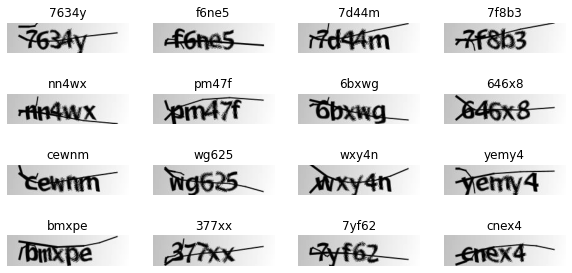

In [ ]:
# Visualize images
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### <b> Model Building

In [ ]:
# Defining CTC loss- https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c
class CTCLayer(layers.Layer):
  def __init__(self,name=None):
    super().__init__(name=name)
    self.loss_fn=tf.keras.backend.ctc_batch_cost           # intializing loss function as ctc_batch_cost that accepts 4 inputs

  def call(self,y_true,y_pred):
    # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    # At test time, just return the computed predictions
    return y_pred

In [ ]:
# Build the model using functional layer structure
def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D( 64, (3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2" )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [ ]:
# Training
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 [==============================] - 35s 394ms/step - loss: 21.9105 - val_loss: 16.4290
Epoch 2/100
59/59 [==============================] - 22s 373ms/step - loss: 16.3666 - val_loss: 16.3927
Epoch 3/100
59/59 [==============================] - 21s 361ms/step - loss: 16.3483 - val_loss: 16.3842
Epoch 4/100
59/59 [==============================] - 21s 360ms/step - loss: 16.3415 - val_loss: 16.3820
Epoch 5/100
59/59 [==============================] - 21s 361ms/step - loss: 16.3355 - val_loss: 16.3846
Epoch 6/100
59/59 [==============================] - 21s 359ms/step - loss: 16.3296 - val_loss: 16.3744
Epoch 7/100
59/59 [==============================] - 22s 374ms/step - loss: 16.3153 - val_loss: 16.3678
Epoch 8/100
59/59 [==============================] - 21s 360ms/step - loss: 16.3097 - val_loss: 16.3381
Epoch 9/100
59/59 [==============================] - 21s 360ms/step - loss: 16.2728 - val_loss: 16.2693
Epoch 10/100
59/59 [==============================] - 21s 359ms/

### <b> Getting Output Predictions

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

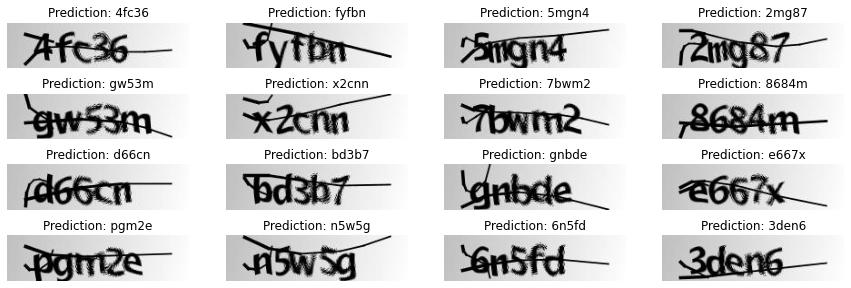

In [ ]:

#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

<b> Hence we have successfully obtained the output predictions on test data.